In [1]:
import os 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import image
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow.keras.layers as tfl
from tensorflow import keras
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [6]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
directory = "C:/Users/Omar/Downloads/asl_dataset"
train_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.3,
                                             subset='training',
                                             seed=42, label_mode='categorical')
validation_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.3,
                                             subset='validation',
                                             seed=42, label_mode='categorical')

Found 2515 files belonging to 36 classes.
Using 1761 files for training.
Found 2515 files belonging to 36 classes.
Using 754 files for validation.


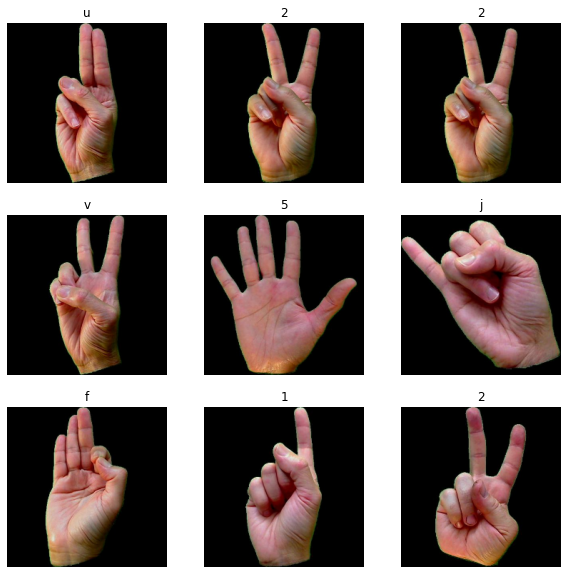

In [5]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [7]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

In [8]:
def data_augmenter():
  data_augmentation = tf.keras.Sequential()
  data_augmentation.add(RandomFlip('horizontal'))
  data_augmentation.add(RandomRotation(0.2))
  return data_augmentation

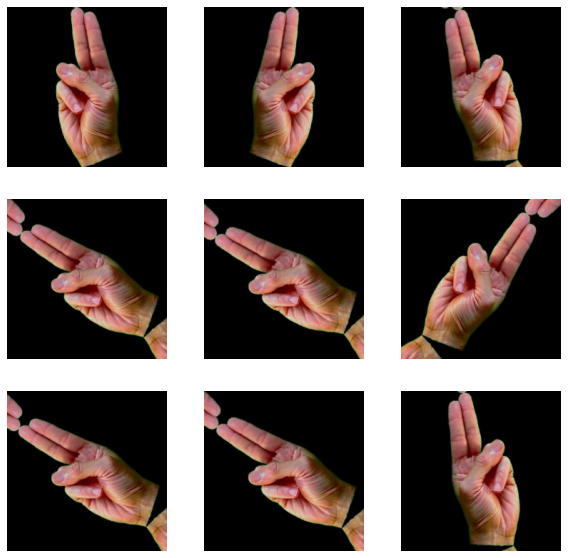

In [9]:
data_augmentation = data_augmenter()

for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

In [10]:
preprocess_input = tf.keras.applications.mobilenet.preprocess_input

In [11]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.mobilenet.MobileNet(input_shape=IMG_SHAPE,
                                               include_top=True,
                                               weights='imagenet')

17225924/17225924 [==============================] - 16s 1us/step


In [12]:
base_model.summary()


Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                         

                                                                 
 conv_pw_8_bn (BatchNormaliz  (None, 14, 14, 512)      2048      
 ation)                                                          
                                                                 
 conv_pw_8_relu (ReLU)       (None, 14, 14, 512)       0         
                                                                 
 conv_dw_9 (DepthwiseConv2D)  (None, 14, 14, 512)      4608      
                                                                 
 conv_dw_9_bn (BatchNormaliz  (None, 14, 14, 512)      2048      
 ation)                                                          
                                                                 
 conv_dw_9_relu (ReLU)       (None, 14, 14, 512)       0         
                                                                 
 conv_pw_9 (Conv2D)          (None, 14, 14, 512)       262144    
                                                                 
 conv_pw_9

In [13]:
nb_layers = len(base_model.layers)
print(base_model.layers[nb_layers - 2].name)
print(base_model.layers[nb_layers - 1].name)

reshape_2
predictions


In [14]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)
label_batch

(32, 1000)


<tf.Tensor: shape=(32, 36), dtype=float32, numpy=
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>

In [15]:
base_model.trainable = False
image_var = tf.Variable(preprocess_input(image_batch))
pred = base_model(image_var)

tf.keras.applications.mobilenet.decode_predictions(pred.numpy(), top=2)

[[('n03485794', 'handkerchief', 0.119133756),
  ('n04033901', 'quill', 0.09109292)],
 [('n03929660', 'pick', 0.31871048), ('n02786058', 'Band_Aid', 0.15124121)],
 [('n02786058', 'Band_Aid', 0.44052795), ('n03793489', 'mouse', 0.15949251)],
 [('n02786058', 'Band_Aid', 0.8989646), ('n01776313', 'tick', 0.0107444115)],
 [('n02786058', 'Band_Aid', 0.5675761), ('n03929660', 'pick', 0.111884154)],
 [('n12267677', 'acorn', 0.35603783), ('n01955084', 'chiton', 0.3285647)],
 [('n02786058', 'Band_Aid', 0.4130827), ('n03929660', 'pick', 0.06473932)],
 [('n02786058', 'Band_Aid', 0.41228104), ('n09229709', 'bubble', 0.04743061)],
 [('n02786058', 'Band_Aid', 0.40557152), ('n03929660', 'pick', 0.3831815)],
 [('n02786058', 'Band_Aid', 0.21294786),
  ('n01930112', 'nematode', 0.07291684)],
 [('n02786058', 'Band_Aid', 0.35449824), ('n03929660', 'pick', 0.08105802)],
 [('n02786058', 'Band_Aid', 0.23420043),
  ('n03250847', 'drumstick', 0.22939849)],
 [('n02786058', 'Band_Aid', 0.8934669),
  ('n03250847',

In [16]:
def asl_model(image_shape = IMG_SIZE, data_augmentation = data_augmenter()):
  input_shape = image_shape + (3,)
  base_model = tf.keras.applications.mobilenet.MobileNet(input_shape=input_shape,
                                                   include_top=False, #removes the top level layers; output layers
                                                   weights='imagenet') # From imageNet
  base_model.trainable = False
  inputs = tf.keras.Input(shape=input_shape)
  x = data_augmentation(inputs)
  x = preprocess_input(x) 
  x = base_model(x, training=False) 
  x = tfl.GlobalAveragePooling2D()(x)
  
  prediction_layer = tfl.Dense(36,activation="softmax")
  outputs = prediction_layer(x)

  model = tf.keras.Model(inputs, outputs)
  return model

In [17]:
model = asl_model(IMG_SIZE, data_augmentation)


17225924/17225924 [==============================] - 16s 1us/step


In [18]:
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                             

In [19]:
lr = 0.01
model.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=['accuracy'])

In [20]:
initial_epochs = 50
with tf.device('/device:GPU:1'):
    history = model.fit(train_dataset, validation_data=validation_dataset, epochs=initial_epochs)

Epoch 1/50
56/56 [==============================] - 38s 653ms/step - loss: 2.9195 - accuracy: 0.2402 - val_loss: 2.0730 - val_accuracy: 0.4695
Epoch 2/50
56/56 [==============================] - 39s 694ms/step - loss: 1.7153 - accuracy: 0.5809 - val_loss: 1.4345 - val_accuracy: 0.6631
Epoch 3/50
56/56 [==============================] - 40s 722ms/step - loss: 1.2308 - accuracy: 0.7359 - val_loss: 1.0772 - val_accuracy: 0.7653
Epoch 4/50
56/56 [==============================] - 39s 694ms/step - loss: 0.9694 - accuracy: 0.7888 - val_loss: 0.9192 - val_accuracy: 0.8037
Epoch 5/50
56/56 [==============================] - 39s 699ms/step - loss: 0.7870 - accuracy: 0.8302 - val_loss: 0.7792 - val_accuracy: 0.8382
Epoch 6/50
56/56 [==============================] - 41s 730ms/step - loss: 0.6890 - accuracy: 0.8512 - val_loss: 0.6960 - val_accuracy: 0.8369
Epoch 7/50
56/56 [==============================] - 42s 753ms/step - loss: 0.6003 - accuracy: 0.8785 - val_loss: 0.6411 - val_accuracy: 0.8568

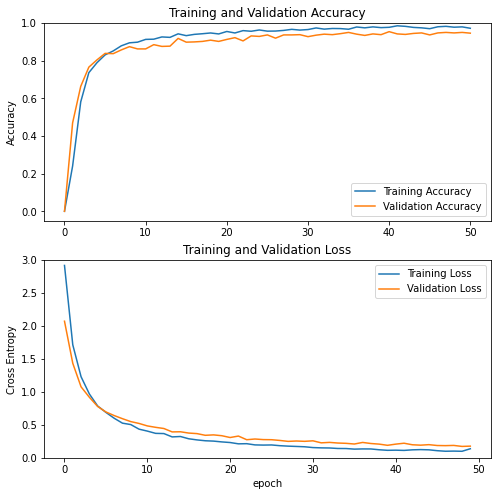

Highest Accuracy: 98.46677780151367%
Highest Validation Accuracy: 95.3580915927887%


In [21]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,3.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()
print('Highest Accuracy: {}%'.format(max(history.history['accuracy'])*100))
print('Highest Validation Accuracy: {}%'.format(max(history.history['val_accuracy'])*100))

In [22]:
model.save('C:/Users/Omar/Downloads/MobileNet')

INFO:tensorflow:Assets written to: C:/Users/Omar/Downloads/MobileNet\assets


INFO:tensorflow:Assets written to: C:/Users/Omar/Downloads/MobileNet\assets
